In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats

## I. Readying Data  
In this section, I'll:  
- import data  
- check data for missing/problematic values

In [2]:
df = pd.read_csv('healthcare_analysis_data.csv')

In [3]:
df.head()

,contract_id,contract_name,complaints_2016,complaints_2017,complaints_2018,complaints_2019,leaving_2016,leaving_2017,leaving_2018,leaving_2019,care_2016,care_2017,care_2018,care_2019
0,H0104,Blue Cross And Blue Shield Of Alabama,0.09,0.04,0.04,0.04,0.06,0.03,0.04,0.03,0.89,0.86,0.85,0.85
1,H0154,"Viva Health, Inc.",0.06,0.06,0.06,0.05,0.06,0.07,0.05,0.05,0.87,0.87,0.86,0.87
2,H0251,"Unitedhealthcare Plan Of The River Valley, Inc.",0.16,0.12,0.13,0.12,0.10,0.09,0.08,0.05,0.88,0.86,0.85,0.87
3,H0294,Care Improvement Plus Wisconsin Insurance Company,0.25,0.22,0.17,0.04,0.13,0.22,0.16,0.11,0.84,0.86,0.85,0.85
4,H0302,"Medisun, Inc.",0.16,0.20,0.14,0.13,0.05,0.10,0.08,0.19,0.82,0.82,0.84,0.79


Let's make sure that each contract id and contract name only appears once in their respective columns:

In [4]:
if df.contract_id.value_counts().size == df.contract_id.size:
    print('Every value in the contract_id column is unique')
    
if df.contract_name.value_counts().size == df.contract_name.size:
    print('Every value in the contract_name column is unique')
else:
    print('Not every value in the contract_name column is unique')

print('There are ' + str(df.contract_id.value_counts().size) + ' unique contract_id values')
print('There are ' + str(df.contract_name.value_counts().size) + ' unique contract_name values')

Every value in the contract_id column is unique
Not every value in the contract_name column is unique
There are 267 unique contract_id values
There are 229 unique contract_name values


It appears that we have multiple contracts awarded to the same company; while this wasn't the initial expectation, a quick sanity check confirms that this is still totally fine and doesn't indicate any immediate problems with the data.

Contract ID and name aside, we have 12 columns of interest (complaints, leaving rate, and care access for 2016-2019). 
For each of these, I'll take a look at the descriptive stats and plot the frequencies of all unique values within each column, to check for unusual or missing (NaN) values.

In [208]:
for col in df.columns:
    print('Does '+col+' have null values?: ' + str(df[col].isnull().values.any()))

Does contract_id have null values?: False
Does contract_name have null values?: False
Does complaints_2016 have null values?: False
Does complaints_2017 have null values?: False
Does complaints_2018 have null values?: False
Does complaints_2019 have null values?: False
Does leaving_2016 have null values?: False
Does leaving_2017 have null values?: False
Does leaving_2018 have null values?: False
Does leaving_2019 have null values?: False
Does care_2016 have null values?: False
Does care_2017 have null values?: False
Does care_2018 have null values?: False
Does care_2019 have null values?: False


In [122]:
means_dict = {}
stds_dict = {}

for col in df.columns:
    describe = df[col].describe()
    if col != 'contract_id' and col != 'contract_name':
        # store the column means and stdevs for later use
        means_dict[col] = describe[1]
        stds_dict[col] = describe[2]
    print(describe)
    

count       267
unique      267
top       H0104
freq          1
Name: contract_id, dtype: object
count                                    267
unique                                   229
top       Unitedhealthcare Insurance Company
freq                                       8
Name: contract_name, dtype: object
count    267.000000
mean       0.165468
std        0.163544
min        0.000000
25%        0.060000
50%        0.130000
75%        0.215000
max        1.590000
Name: complaints_2016, dtype: float64
count    267.000000
mean       0.161386
std        0.162968
min        0.000000
25%        0.060000
50%        0.120000
75%        0.190000
max        1.440000
Name: complaints_2017, dtype: float64
count    267.000000
mean       0.133296
std        0.127685
min        0.000000
25%        0.060000
50%        0.100000
75%        0.170000
max        1.190000
Name: complaints_2018, dtype: float64
count    267.000000
mean       0.127266
std        0.111657
min        0.000000
25%        0.0

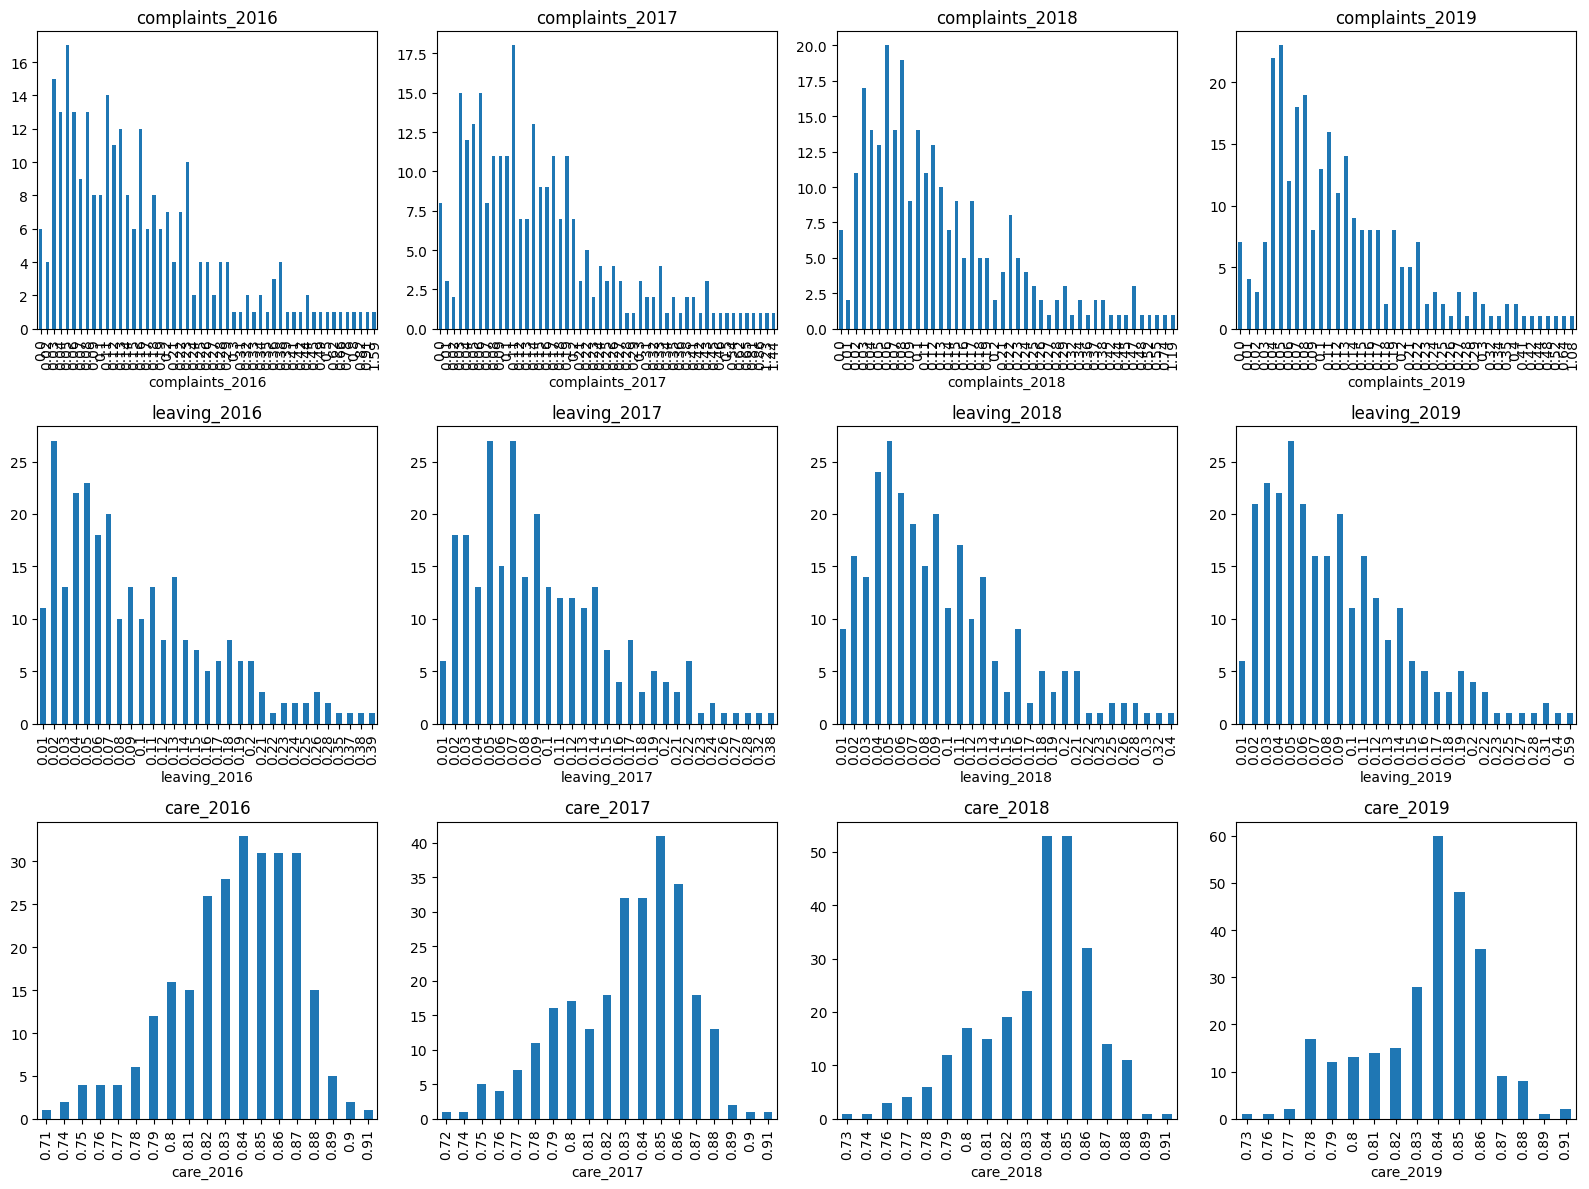

In [107]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))


for i, ax in enumerate(axes.flatten()):
    col = df.columns[i+2]
    df[col].value_counts().sort_index().plot.bar(ax=ax)
    ax.set_title(col)

plt.tight_layout()

From the above plots, it looks like all 12 of the columns of interest have reasonably normal distributions. Most are slightly skewed, but there are no notable outliers and for each measure we can still roughly assume normality (we can test this more strenuously down the line if needed).  
Moreover, it looks like each measure (complaints, leaving, care) keeps roughly the same distribution shape for the 4 years over which it was measured (for example, complaints has a right skew and highest density at around 0.06 for 2016-2019), which aligns with expectations.

## II. Exploratory Analyses

### Are complaints, leaving, and care correlated?  
We would expect that they are. For example, if a plan has an especially high complaint rate or if patients feel they are not getting the care they need from the plan, we'd expect that the plan also has a higher rate of patients leaving the plan. What's not clear is how we can rank these relations; is complaint rate or sentiment about care more correlated to leaving rate?  
For simplicity, we'll look only at data from 2019, since if a correlation exists in one year it should exist during the others too. We'll start with pairwise scatter plots, then a correlation heatmap.

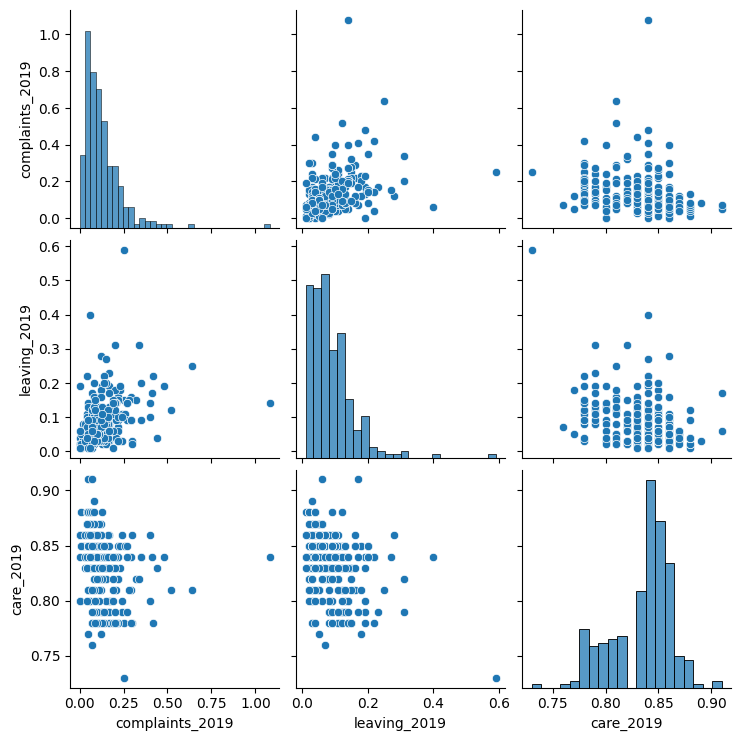

In [7]:
# isolate only the data pertinent to 2019 data
cols_2019 = ['complaints_2019', 'leaving_2019', 'care_2019']
df_2019 = df[cols_2019]

# plot 3x3 grid of paired scatterplots
sns.pairplot(df_2019)

From observation, it looks like only the (complaints, leaving) and (leaving, care) pairs could be correlated. This is made apparent by the fact that, for the other scatterplots present, an increase in one variable isn't matched by an increase/decrease in the variable it is plotted against (see bottom left plot). On the other hand, in the middle left plot, as complaints increases, there is at least some increase in the leaving rate.  

We'll look at the correlation heatmap next to quantify these observations.

<Axes: >

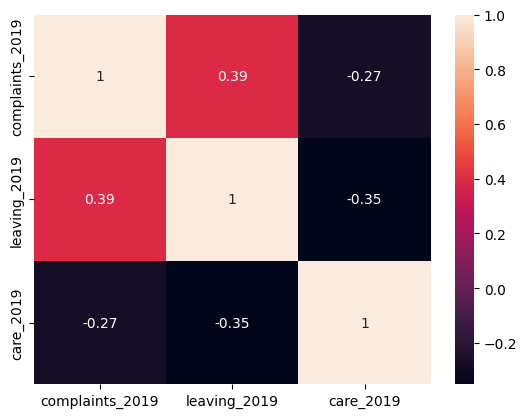

In [8]:
sns.heatmap(df_2019.corr(), annot=True)

The above heatmap, combined with the scatterplots we saw before, tell us that our hunch was right - complaints and care are the most strongly correlated with the leaving rate. One thing to note is that all of the magnitudes we're looking at are < 0.4, which means that the correlations are weak at best. However, as an exploratory measure we can still use these correlations to answer our question.  
The correlation value of 0.39 for leaving against complaints is the strongest and tells us that, as complaints increases, there is a corresponding *increase* in the leaving rate. This matches with what we'd expect - the more complaints patients have about a plan, the less satisfied they are about it, and the more they will leave the plan.
The correlation value of -0.35 for leaving against care is the second strongest and tells us that, as care rating increases, there is a corresponding *decrease* in the leaving rate. This also matches with what we expect; the better patients feel about the care they get, the less they will leave a plan.  


### Are there trends over time?  
Does the number of complaints increase year over year? Does sentiment about quality of care trend more positive year over year?  
**What does this help us with?** If we're using year-over-year (YOY) performance as a determiner of plan quality, we'd look at a plan which has (for example) increasing year over year leaving rate as a candidate for a bad plan. However, if there's an overall trend for leaving rates increasing, we might be inclined to give that plan a pass. If, on the other hand, there's an overall trend for better care quality YOY but a particular plan worsens in that aspect, then that'd solidify our concern over that plan.

We'll plot overall means for each year and perform t-tests to see if any differences year-to-year are significant.

In [10]:
# a helper function to get YOY and start-end p-values for a dataframe with a measure's values over 2016-2019
def YOY_pvals(df):
    # there will be 4 p-values for each measure: 2016-2017, 2017-2018, 2018-2019 and 2016-2019
    pvals = []  # the list of p-vals to return
    for colnum in range(1, 4):
        # we'll perform a paired t-test since the samples we're comparing are taken from the same subjects but at different time points
        res = stats.ttest_rel(df[df.columns[colnum-1]], df[df.columns[colnum]])
        pvals.append(res[1])
    pvals.append(stats.ttest_rel(df[df.columns[0]], df[df.columns[3]])[1])
    
    return pvals

[0.6551283397687055, 2.729005512335553e-05, 0.33960047678863703, 1.1182204033610673e-05]
[0.755644177001536, 0.26144995376733976, 0.32250108891383833, 0.06817146426375671]
[0.0057300129367398546, 0.007568679099632102, 0.4674280524129125, 0.5343779660236913]


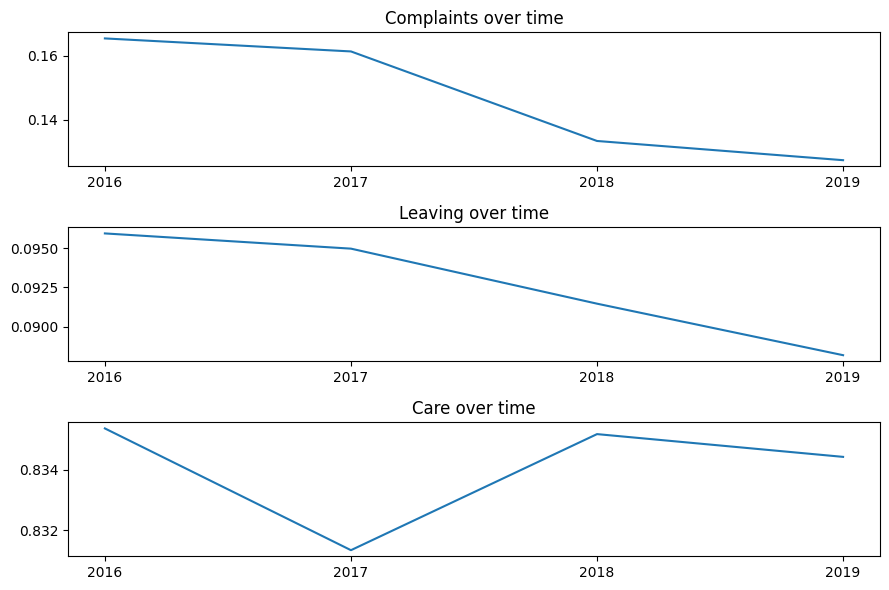

In [188]:
measures = ['Complaints', 'Leaving', 'Care']
years = ['2016', '2017', '2018', '2019']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9,6))

for i, ax in enumerate(axes.flatten()):
    cols = df.columns[(i*4)+2:(i*4)+6]
    pvals = YOY_pvals(df[cols])
    print(pvals)
    col_means = list(df[cols].mean())
    ax.plot(col_means)
    ax.set_title(measures[i] + ' over time')
    ax.set_xticks(np.arange(0,4,1))
    ax.set_xticklabels(years)

plt.tight_layout()

From the above, the most significant trend is that of **average complaints over time decreasing from 2016 to 2019**. This is due in large part to the significant decrease from 2017 to 2018, but it appears that the average does slightly decrease every year over the entire period.  
Though it appears that leaving rate also follows a similar trend, a glance at the y-axis values shows that the ostensible decrease in leaving rate from 2016 to 2019 is just a fraction of a percentage point. This is further supported by the lack of a significant p-value from the paired t-test comparing leaving rates from 2016 to those of 2019. 

## III. Evaluation  
An important step is deciding what combinations of which metrics we'll use to evaluate the quality of a plan. For our first pass at the problem, we might say that the rate of patients leaving a plan is an ultimate determiner of its quality. If, for example, patients rate the quality of care of a plan as low, but the plan still has a low rate of patients leaving, there could be other facets of the plan that are appealing to patients that haven't been captured by the data we're given. However, if the leaving rate is high, that gives us definite information about quality/perception about the plan.

We saw before that there was no statistically significant directionality, either YOY or overall from 2016-2019, to the leaving rate over those four years. This means we can look at plans' leaving rates over 2016-2019 without any expectations about overall directionality. Let's first seek out those **plans which had higher than average leaving rates for all four years**. We're using this as the first and thus most important metric since high leaving rates for all four years points to consistently poor quality.

### Plans with consistently high leaving rates

In [124]:
bad_l = df.loc[(df['leaving_2016'] > means_dict['leaving_2016']) &
                  (df['leaving_2017'] > means_dict['leaving_2017']) &
                  (df['leaving_2017'] > means_dict['leaving_2018']) &
                  (df['leaving_2017'] > means_dict['leaving_2019'])
                 ]

In [125]:
bad_l.shape

(89, 14)

Our resulting dataframe has 89 rows. This means that there are 89 contracts with higher-than-average leaving rates across each of the four years from 2016 to 2019. Considering that we found early in the EDA that leaving rate distributions skew right, meaning most of their data actually exists above the mean, this is not surprising. To narrow down the data, we should impose a higher cutoff: what about plans that had leaving rates higher than 1 standard deviation above the mean? This should reduce the number of plans considerably.

In [127]:
worse_l = df.loc[(df['leaving_2016'] > means_dict['leaving_2016'] + stds_dict['leaving_2016']) &
                      (df['leaving_2017'] > means_dict['leaving_2017'] + stds_dict['leaving_2017']) &
                      (df['leaving_2017'] > means_dict['leaving_2018'] + stds_dict['leaving_2018']) &
                      (df['leaving_2017'] > means_dict['leaving_2019'] + stds_dict['leaving_2019'])
                     ]

In [128]:
worse_l.shape

(28, 14)

As expected, this narrows down the field quite a bit. Now, we can use our next-most important metric to further rank the options we're left with. (I did not choose an even higher cutoff, such as 2 standard deviations above the mean, since I wanted there to be enough data remaining for the next metric to have a meaningful impact in differentiating the remaining data).  
The plans we are left with all have consistently high leaving rates. How can we further differentiate between these? We can turn to one of care or complaints YOY as our next decider. Since we saw earlier in our EDA that complaint rate is more highly correlated with leaving rate than care is (although both correlations are weak), our use of leaving rate as the first deciding metric will ostensibly have captured more of the input from complaints rate data than care. Thus, to maximize the amount of new information gained, let's use YOY quality of care (the less correlated field) to further rank the data. We'll see **which plans from the ones with consistently high leaving rate also have lower-than-average quality of care over each of the four years.**

### Plans with consistently high leaving rates AND low quality of care

In [129]:
bad_lc = worse_l.loc[(worse_l['care_2016'] < means_dict['care_2016']) & 
                     (worse_l['care_2017'] < means_dict['care_2017']) &
                     (worse_l['care_2018'] < means_dict['care_2018']) &
                     (worse_l['care_2019'] < means_dict['care_2019'])
]

In [130]:
bad_lc.shape

(13, 14)

In [131]:
bad_lc

,contract_id,contract_name,complaints_2016,complaints_2017,complaints_2018,complaints_2019,leaving_2016,leaving_2017,leaving_2018,leaving_2019,care_2016,care_2017,care_2018,care_2019
7,H0351,"Health Net Of Arizona, Inc.",0.22,0.27,0.22,0.25,0.17,0.38,0.20,0.15,0.74,0.76,0.79,0.78
24,H0913,"Wellcare Health Plans Of New Jersey, Inc.",0.22,1.23,0.22,0.64,0.19,0.28,0.23,0.25,0.78,0.75,0.80,0.81
41,H1415,Healthspring Life & Health Insurance Company,0.39,0.30,0.25,0.10,0.17,0.17,0.20,0.12,0.80,0.80,0.78,0.79
55,H2029,"Humana Insurance Of Puerto Rico, Inc.",0.50,0.81,0.52,0.52,0.18,0.32,0.19,0.12,0.80,0.81,0.74,0.81
56,H2108,"Bravo Health Mid-atlantic, Inc.",0.45,0.41,0.47,0.22,0.19,0.17,0.18,0.09,0.75,0.78,0.80,0.82
107,H3347,"Elderplan, Inc.",0.22,0.28,0.24,0.17,0.19,0.17,0.26,0.23,0.78,0.80,0.79,0.79
113,H3387,"Unitedhealthcare Of New York, Inc.",0.33,0.33,0.22,0.22,0.24,0.22,0.19,0.15,0.79,0.76,0.79,0.78
135,H3815,Alignment Health Plan,0.19,0.15,0.16,0.11,0.21,0.26,0.13,0.13,0.80,0.75,0.80,0.80
176,H5087,Easy Choice Health Plan Inc.,0.16,0.16,0.07,0.07,0.35,0.24,0.12,0.12,0.77,0.77,0.73,0.78
204,H5549,Vns Choice,0.22,0.20,0.29,0.34,0.19,0.22,0.18,0.31,0.75,0.80,0.81,0.82


From a total of 267 contracts, we've isolated 13 of the worst ones by the standards we've defined. Since I want to leverage the notable information we've gained from exploratory analyses, let's next look at the complaint rate - specifically those **plans which did not show a decrease in complaints from 2016 to 2019**. I'm choosing this since we found that the most meaningful and statistically significant trend from 2016-2019 in our data was a decrease in complaints from 2016 to 2019 across all plans. So, any plans which buck this trend must be doing considerably worse than their counterparts. 

### Poor-performance plans with an increase in or same level of complaints

In [132]:
bad_lcc = bad_lc.loc[bad_lc['complaints_2016'] <= bad_lc['complaints_2019']]

In [134]:
bad_lcc.shape

(6, 14)

We've arrived at six poorly performing plans. To make the final cut to five, we can fall back on what we previously determined was our most important metric, i.e. leaving rate. Since we've already evaluated on the YOY basis, here let's get rid of the plan with the lowest leaving rate in 2019. We choose 2019 since it is the most recent data and thus most salient. 

In [139]:
worst_lcc = bad_lcc[bad_lcc['leaving_2019'] > np.min(bad_lcc['leaving_2019'])]

In [140]:
worst_lcc

,contract_id,contract_name,complaints_2016,complaints_2017,complaints_2018,complaints_2019,leaving_2016,leaving_2017,leaving_2018,leaving_2019,care_2016,care_2017,care_2018,care_2019
7,H0351,"Health Net Of Arizona, Inc.",0.22,0.27,0.22,0.25,0.17,0.38,0.20,0.15,0.74,0.76,0.79,0.78
24,H0913,"Wellcare Health Plans Of New Jersey, Inc.",0.22,1.23,0.22,0.64,0.19,0.28,0.23,0.25,0.78,0.75,0.80,0.81
204,H5549,Vns Choice,0.22,0.20,0.29,0.34,0.19,0.22,0.18,0.31,0.75,0.80,0.81,0.82
214,H5656,"Selectcare Health Plans, Inc.",0.12,0.19,0.11,0.17,0.18,0.20,0.21,0.17,0.77,0.75,0.76,0.79
247,H8554,Ghs Insurance Company,0.18,0.41,0.38,0.25,0.23,0.19,0.18,0.59,0.83,0.82,0.82,0.73


We have our five worst performing plans!  
To recap the decision process, we first picked from 267 plans those that exhibited high (greater than 1 std above the mean) leaving rates for all four years, since we rationalized that high leaving rate should be the best indicator of poor plan quality. Out of the remaining 28 plans, we then picked plans with lower (lower than the mean) quality of care, since quality of care was less correlated with leaving rate and would thus provide us with more non-redundant information. Finally, since we observed that plans on average had fewer complaints in 2019 than in 2016, we picked from the remaining 11 plans those that did not have improved complaint rates, and then dropped the plan with lowest leaving rate in 2019, leaving us with the 5 plans, that, according to our insight, required the most further attention. 

## IV. Visualizing results  
Let's plot the means of all of the fields in our data, placing the corresponding fields of our five plans on those plots. This will help us see just where these individual plans stand in comparison to the rest of the data that we have.

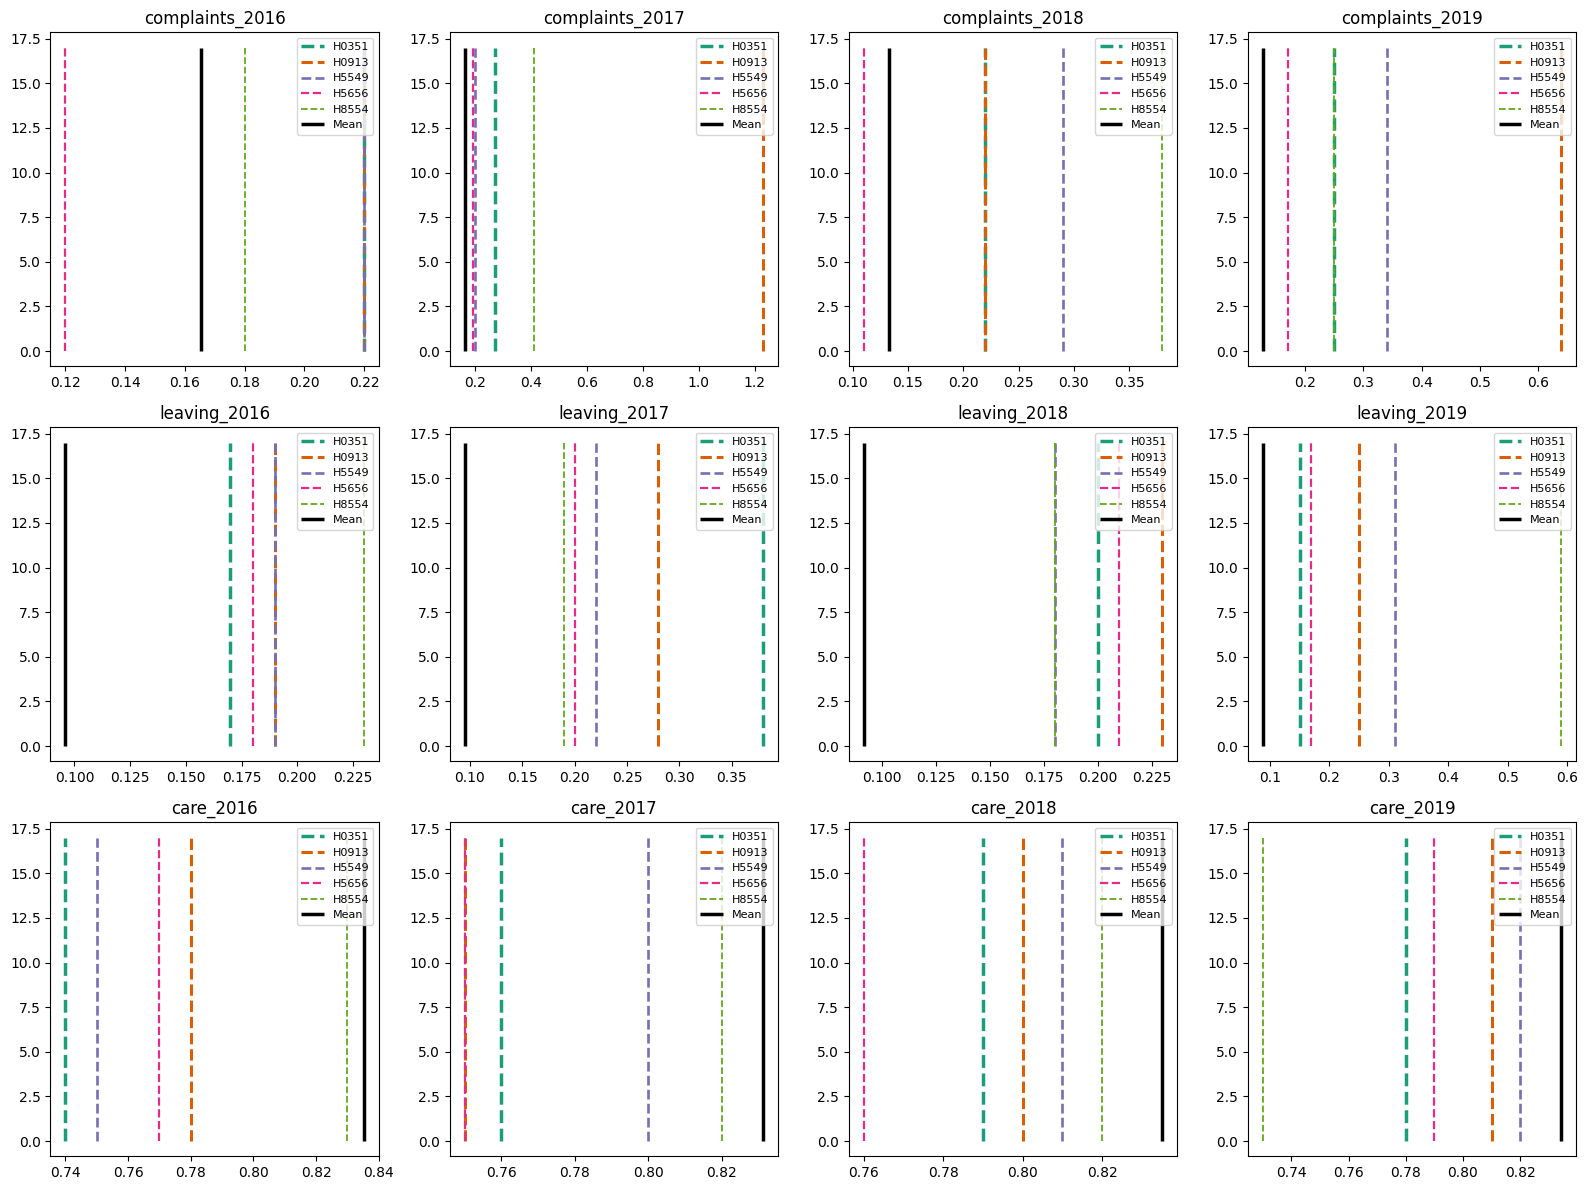

In [200]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
cmap = mpl.colormaps['Dark2']

for i, ax in enumerate(axes.flatten()):
    col = df.columns[i+2]
    
    c=0
    w=2.5
    for plan_idx in worst_lcc.index:
        data = worst_lcc.loc[plan_idx]
        ax.vlines(data[col], ymin=0, ymax=max(counts), 
                  color=cmap(c), linestyle='dashed', linewidth=w, 
                  label=data['contract_id'])
        c+=1
        w-=0.3
    ax.vlines(means_dict[col], ymin=0, ymax=max(counts), color='black', linestyle='solid', linewidth=2.5, label='Mean')

    ax.set_title(col)
    ax.legend(loc='best', fontsize=8)

plt.tight_layout()

While this does show us where the five plans lie in relation to the means each year, it isn't the most informative or efficient - for a more compact depiction of wehre the five plans lie in relation to all of the others, let's try a 3-D scatterplot for the three measures in 2019 and label our five problem plans.

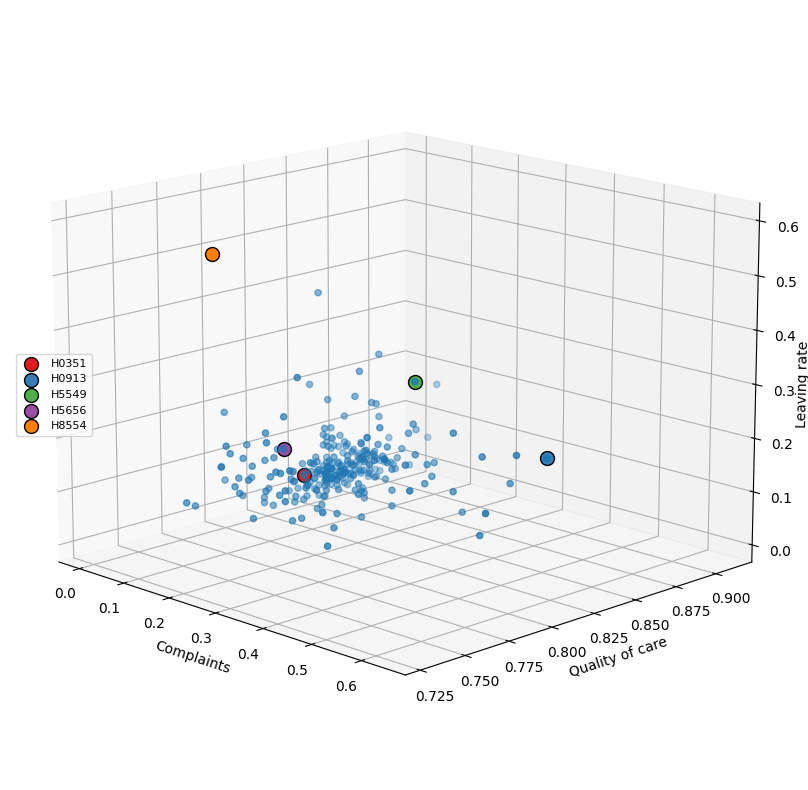

In [289]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

temp = df.loc[df['complaints_2019'] < 0.8]
x = temp['complaints_2019']
y = temp['care_2019']
z = temp['leaving_2019']

# plot all points
ax.scatter(x, y, z, zorder=1)

# highlight the five plans
cmap = mpl.colormaps['Set1']
c=0
for plan_idx in worst_lcc.index:
    data = worst_lcc.loc[plan_idx]
    ax.scatter(data['complaints_2019'], data['care_2019'], data['leaving_2019'], 
               color=cmap(c), s=100, alpha=1, edgecolor='black',
               zorder=2, label=data['contract_id'])
#     ax.text(data['complaints_2019'], data['care_2019'], data['leaving_2019'], '  ' + str(data['contract_id']),
#             zorder=3)
    c+=1

ax.set_xlabel('Complaints')
ax.set_ylabel('Quality of care')
ax.set_zlabel('Leaving rate')
ax.legend(loc='center left', fontsize=8)
ax.zaxis.labelpad=-1.5

ax.view_init(15, -45)
plt.tight_layout()
currentfig = plt.gcf()

In [290]:
currentfig.savefig(r'C:\Users\kevin\Documents\Job Search\Take Home\EmendataTop5_Scatter.jpg', format="jpg", bbox_inches="tight", dpi=300)

It is interesting to note that the plans chosen for investigation are not clustered together. This is an artifact of our approach using a variety of measures, and may also imply that there isn’t a single determining measure from available data to group poorly performing plans together.


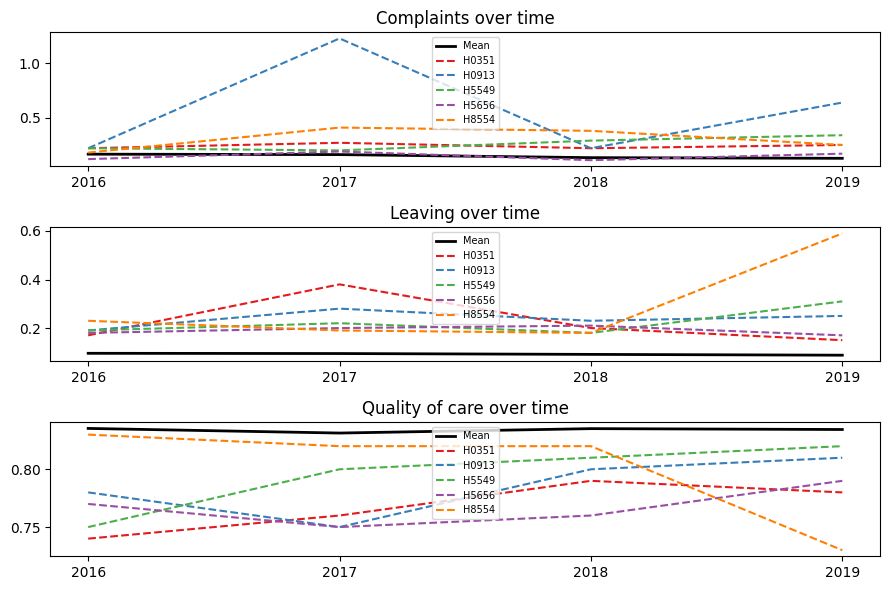

In [263]:
measures = ['Complaints', 'Leaving', 'Quality of care']
years = ['2016', '2017', '2018', '2019']
cmap = mpl.colormaps['Set1']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9,6))

for i, ax in enumerate(axes.flatten()):
    cols = df.columns[(i*4)+2:(i*4)+6]
    col_means = list(df[cols].mean())
    ax.plot(col_means, color='black', linewidth=2, label='Mean')
    
    c=0
    for plan_idx in worst_lcc.index:
        data = worst_lcc.loc[plan_idx]
        ax.plot(data[cols], color=cmap(c), linestyle='dashed',
               label=data['contract_id'])
        c+=1    
    
    ax.set_title(measures[i] + ' over time')
    ax.set_xticks(np.arange(0,4,1))
    ax.set_xticklabels(years)
    ax.legend(loc='upper center', fontsize=7)

plt.tight_layout()
currentfig=plt.gcf()

In [245]:
currentfig.savefig(r'C:\Users\kevin\Documents\Job Search\Take Home\EmendataTop5_YOY.jpg', format="jpg", bbox_inches="tight", dpi=300)

Plan H8554 (orange) in particular shows significant signal in its leaving rate and care quality over 2018 and 2019, with both measures going from best of the pack of five plans in 2018 to the worst in 2019. Additional care might be taken in further investigations to see if GHS Insurance underwent a policy shift or significant changes to its product. 